# Carvana-DCAN

## Imports

In [1]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from optimizers.AdamAccumulate import AdamAccumulate
from models.DCAN_heng import DCAN_Heng
from submit import generate_submit
from utilities import utils_mask_contour
from utilities import losses

%load_ext autoreload
%autoreload 2
%matplotlib inline

Using TensorFlow backend.


In [2]:
utils_mask_contour.set_results_reproducible()

## Preparing Data

In [3]:
input_size = 1024
train_path = "inputs/train/{}.jpg" 
train_mask_path = "inputs/train_masks/{}_mask.gif"
train_contour_path = "inputs/train_contours/{}_contour.png"
df_train = pd.read_csv('inputs/train_masks.csv')
ids_train = df_train['img'].map(lambda s: s.split('.')[0])#[:3000]
ids_train_split, ids_valid_split = train_test_split(ids_train, test_size=0.2, random_state=42)

print('Training on {} samples'.format(len(ids_train_split)))
print('Validating on {} samples'.format(len(ids_valid_split)))

bboxes = None
#bbox_file_path = 'inputs/train_bbox.csv'
#bboxes = utils_mask_contour.get_bboxes(bbox_file_path)

def train_generator(batch_size):
    return utils_mask_contour.train_generator(train_path, train_mask_path, train_contour_path, ids_train_split, 
                                 input_size, batch_size, bboxes)

def valid_generator(batch_size):
    return utils_mask_contour.valid_generator(train_path, train_mask_path, train_contour_path, ids_valid_split, 
                                 input_size, batch_size, bboxes)

Training on 4070 samples
Validating on 1018 samples


### Some Verifications

In [4]:
x, y = next(valid_generator(2))

In [5]:
cont = np.squeeze(y['contour_out'][0])
#cont.shape

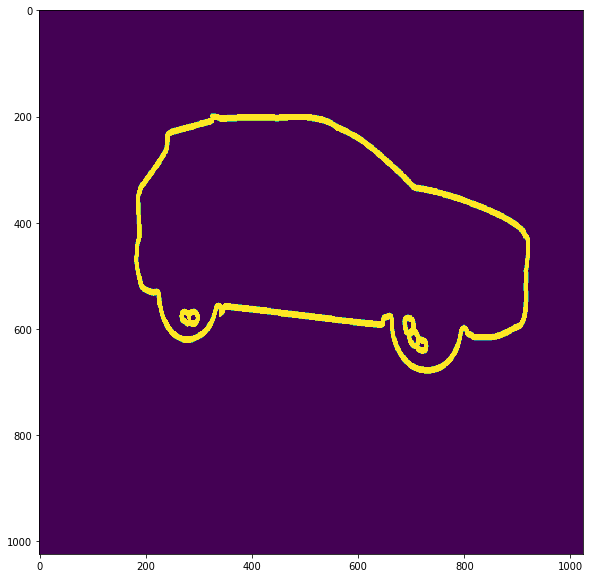

In [6]:
plt.figure(figsize=(10, 10))
plt.imshow(cont)

## Create Model

In [7]:
#DCAN:
model = DCAN_Heng((input_size, input_size, 3))

model.compile(optimizer=AdamAccumulate(accum_iters=32), 
              loss={'seg_out': losses.weighted_bce_dice_loss, 'contour_out': losses.contour_weighted_bce_loss},
                    #'final_seg': weighted_bce_dice_seg_loss}, 
              loss_weights={'seg_out': 1., 'contour_out': 1.},
              metrics={'seg_out': losses.dice_value, 'contour_out': 'binary_accuracy'})

#model.summary()

In [8]:
model.count_params()

51876494

## Fit Model

In [9]:
epochs = 100
batch_size = 1
run_name = utils_mask_contour.get_run_name('weights/{}.hdf5', 'DCAN-heng')
weights_path = 'weights/{}.hdf5'.format(run_name)

callbacks = [EarlyStopping(monitor='val_seg_out_dice_value',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4,
                           mode='max'),
             ReduceLROnPlateau(monitor='val_seg_out_dice_value',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4,
                               mode='max'),
             ModelCheckpoint(monitor='val_seg_out_dice_value',
                             filepath=weights_path,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max'),
             TensorBoard(log_dir='logs/{}'.format(run_name), batch_size=batch_size)]

#model.load_weights('weights/DCAN-heng-2017-09-20-0018.hdf5')
#K.set_value(model.optimizer.lr, 0.01)

print('Starting run "{}"'.format(run_name))
model.fit_generator(generator=train_generator(batch_size),
                    steps_per_epoch=np.ceil(float(len(ids_train_split)) / float(batch_size)),
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=valid_generator(batch_size),
                    validation_steps=np.ceil(float(len(ids_valid_split)) / float(batch_size)))

Starting run "DCAN-heng-2017-09-20-1737"
Epoch 1/100


ResourceExhaustedError: OOM when allocating tensor with shape[1,1024,1024,20]
	 [[Node: training/AdamAccumulate/gradients/zeros_10 = Fill[T=DT_FLOAT, _class=["loc:@activation_19_1/Relu"], _device="/job:localhost/replica:0/task:0/gpu:0"](training/AdamAccumulate/gradients/Shape_11, training/AdamAccumulate/gradients/zeros_10/Const)]]
	 [[Node: loss/seg_out_loss/Mean_3/_2779 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_41800_loss/seg_out_loss/Mean_3", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'training/AdamAccumulate/gradients/zeros_10', defined at:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2828, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-e8f5627e71bb>", line 34, in <module>
    validation_steps=np.ceil(float(len(ids_valid_split)) / float(batch_size)))
  File "/usr/local/lib/python2.7/dist-packages/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/training.py", line 1923, in fit_generator
    self._make_train_function()
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/training.py", line 960, in _make_train_function
    loss=self.total_loss)
  File "optimizers/AdamAccumulate.py", line 35, in get_updates
    grads = self.get_gradients(loss, params)
  File "/usr/local/lib/python2.7/dist-packages/keras/optimizers.py", line 73, in get_gradients
    grads = K.gradients(loss, params)
  File "/usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py", line 2307, in gradients
    return tf.gradients(loss, variables, colocate_gradients_with_ops=True)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gradients_impl.py", line 531, in gradients
    out_grads[i] = control_flow_ops.ZerosLikeOutsideLoop(op, i)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/control_flow_ops.py", line 1323, in ZerosLikeOutsideLoop
    return array_ops.zeros(zeros_shape, dtype=val.dtype)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/array_ops.py", line 1386, in zeros
    output = fill(shape, constant(zero, dtype=dtype), name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 1135, in fill
    result = _op_def_lib.apply_op("Fill", dims=dims, value=value, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1,1024,1024,20]
	 [[Node: training/AdamAccumulate/gradients/zeros_10 = Fill[T=DT_FLOAT, _class=["loc:@activation_19_1/Relu"], _device="/job:localhost/replica:0/task:0/gpu:0"](training/AdamAccumulate/gradients/Shape_11, training/AdamAccumulate/gradients/zeros_10/Const)]]
	 [[Node: loss/seg_out_loss/Mean_3/_2779 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_41800_loss/seg_out_loss/Mean_3", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


## Validation

In [9]:
def np_dice_value(y_true, y_pred):
    smooth = 1.
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

### Some Visulizations

In [18]:
run_name = 'DCAN-2017-09-13-1753'
model.load_weights('weights/{}.hdf5'.format(run_name))

val_imgs_gt, val_masks_contours = next(valid_generator(len(ids_valid_split)))
val_masks_gt = val_masks_contours['seg_out']
val_contours_gt = val_masks_contours['contour_out']

preds = model.predict(val_imgs_gt, batch_size=1)
pred_val_masks = preds[0]
pred_val_contours = preds[1]

#val_pred_masks = np.add(val_pred_masks_contours[0], val_pred_masks_contours[1])
#val_pred_masks = np.divide(pred_masks_contours, 2)

#print val_imgs.shape
#print val_masks.shape
#print val_contour.shape
print pred_val_masks.shape
print pred_val_contours.shape

(1018, 128, 128, 1)
(1018, 128, 128, 1)


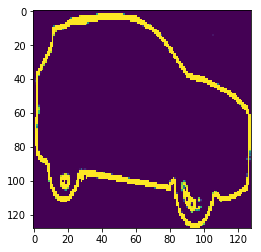

In [19]:
plt.imshow(np.squeeze(pred_val_contours[0]))

In [106]:
pred_masks = np.add(pred_val_masks, val_contours_gt)
pred_masks = pred_masks > 0.99
np_dice_value(val_masks_gt, pred_masks)

0.99722169257410609

In [107]:
pred_masks = np.add(pred_val_masks, pred_val_contours)
pred_masks = pred_masks > 0.999
np_dice_value(val_masks_gt, pred_masks)

0.99588725822691115

0 872
1 573
2 59


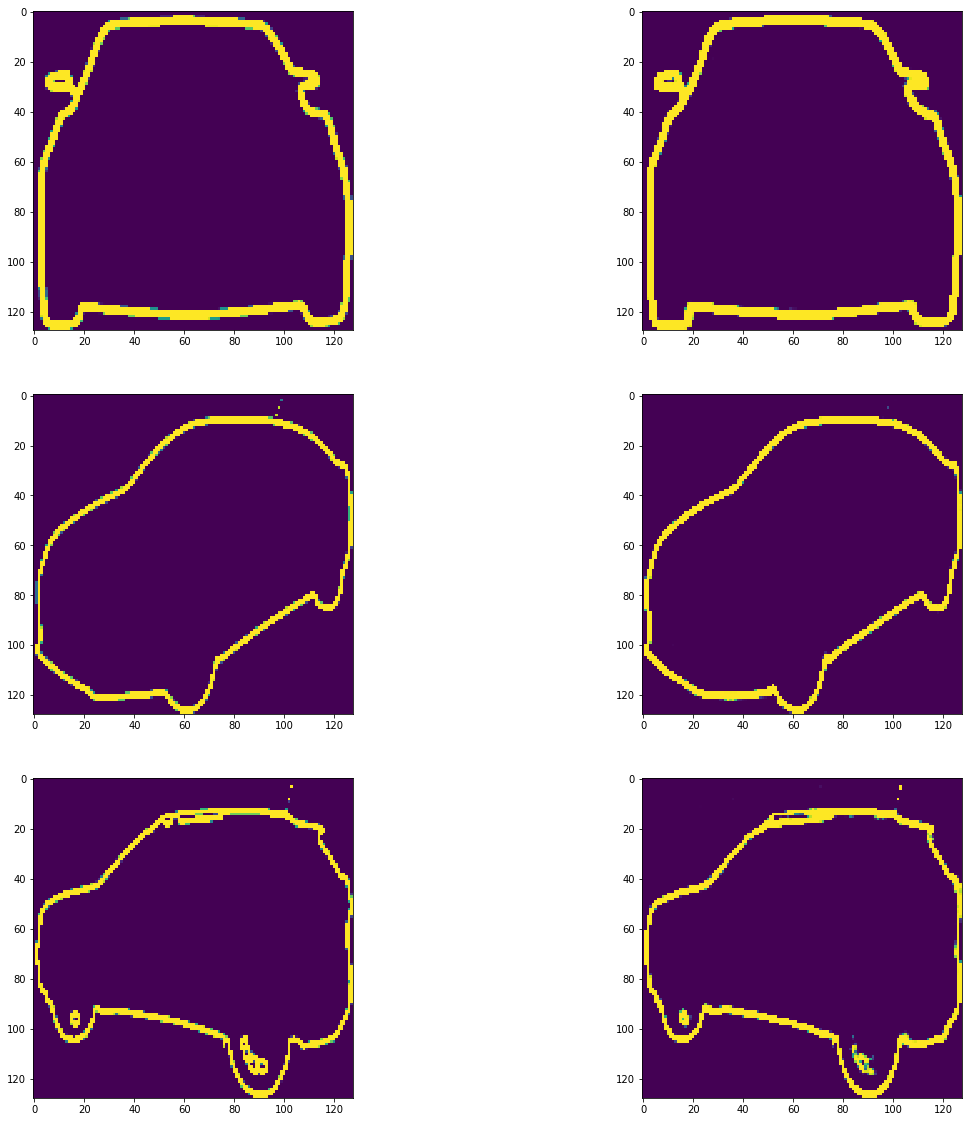

In [110]:
x = np.random.randint(0, len(ids_valid_split)-1, 3)
plt.figure(figsize=(20, 20))
for num, ind in enumerate(x):
    ax1 = plt.subplot(3, 2, 2*num+1)
    ax1.imshow(np.squeeze(val_contours_gt[ind]))
    ax2 = plt.subplot(3, 2, 2*num+2)
    ax2.imshow(np.squeeze(pred_val_contours[ind]))
    print num, ind

### Prediction

In [6]:
run_name = 'unet-2017-09-03-1739'
model.load_weights('weights/{}.hdf5'.format(run_name))

val_imgs, val_masks = next(valid_generator(len(ids_valid_split)))
val_imgs = np.array(val_imgs)
val_masks = np.array(val_masks)
val_pred_masks = model.predict(val_imgs, batch_size=1)
masks_val_dices = [np_dice_value(mask, pred_mask) for (mask, pred_mask) in zip(val_masks, val_pred_masks)]

### Display the worst predicted mask for validation examples

2faf504842df_09 0.99134050897


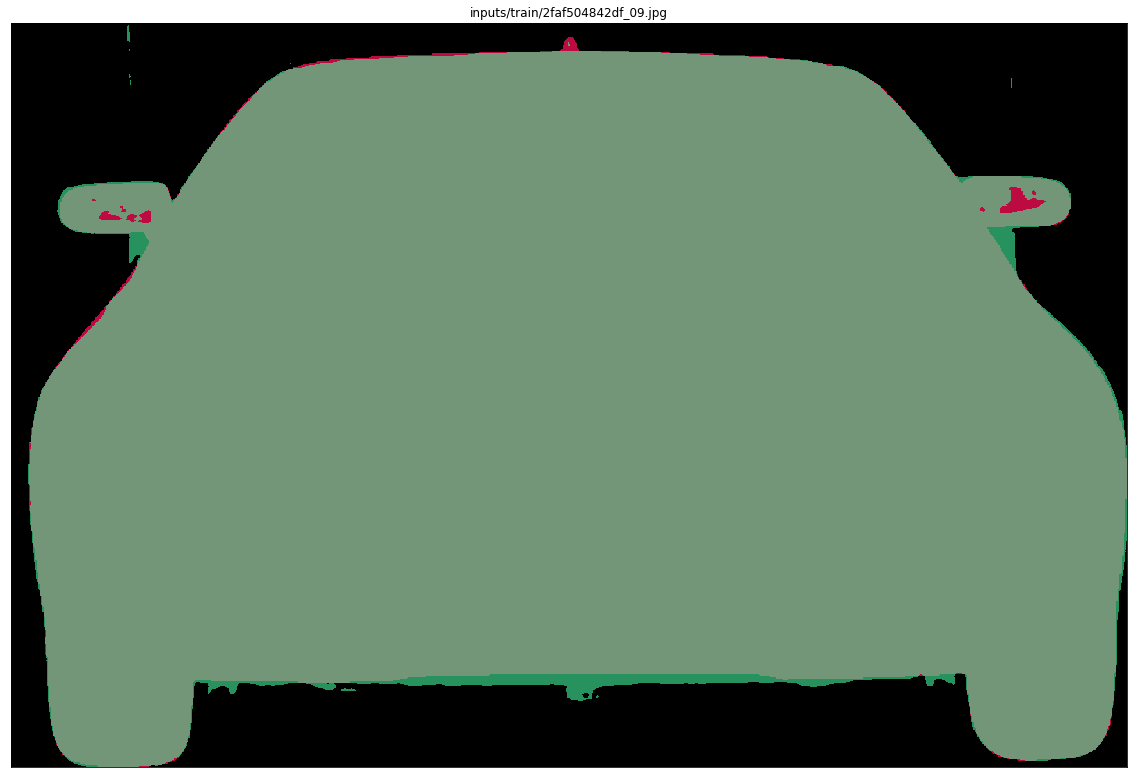

In [20]:
index = np.argsort(masks_val_dices)[7]
id = ids_valid_split.values[index]
utils.show_mask(train_path.format(id), val_masks[index].squeeze(), val_pred_masks[index].squeeze(), show_img=False)
print id, masks_val_dices[index]

### Histogram

In [ ]:
hist, bins = np.histogram(masks_val_dices, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

### Visualization

In [ ]:
indices = np.random.randint(len(ids_valid_split), size=3)
for index in indices:
    id = ids_valid_split.values[index]
    utils.show_mask(train_path.format(id), val_masks[index].squeeze(), val_pred_masks[index].squeeze(),
                    show_img=True, bbox = bboxes[id])

## Test

### Load Model

In [ ]:
# Create model first if required
run_name = 'unet-2017-08-20-5'
model.load_weights('weights/{}.hdf5'.format(run_name))

### Generate Submit

In [ ]:
batch_size = 16
threshold = 0.5
test_path = 'inputs/test1/' #'inputs/test/'
test_masks_path = 'outputs/test1_masks/' #None
generate_submit(model, input_size, batch_size, threshold, test_path, 'outputs/', run_name, test_masks_path)

### Visualization

In [ ]:
utils.show_test_masks(test_path, test_masks_path)